In [1]:
from __future__ import division
import os
import sys

from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
np.set_printoptions(threshold=np.nan)

In [3]:
def read_ms_file(fp):
    with open(fp) as fh:
        ## Skip first two lines
        fh.readline()
        fh.readline()

        ## Parse positions
        positions = map(float, fh.readline().replace('positions: ','').split())

        ## Make genotype array
        seqs = [map(int, j) for j in map(list, [x.strip() for x in fh])]
        gt = np.array(seqs)
        
        return positions,gt

In [4]:
def get_trajectories(baseDir):
    posANC,gtANC = read_ms_file(os.path.join(baseDir,'ms_ANC.txt'))
    posOOA,gtOOA = read_ms_file(os.path.join(baseDir,'ms_OOA.txt'))
    posAFR,gtAFR = read_ms_file(os.path.join(baseDir,'ms_AFR.txt'))
    posEUR,gtEUR = read_ms_file(os.path.join(baseDir,'ms_EUR.txt'))
    posEAS,gtEAS = read_ms_file(os.path.join(baseDir,'ms_EAS.txt'))
    
    ## Determine which positions are shared from beginning
#     shared = set.intersection(set(posANC),set(posOOA),set(posAFR),set(posEUR),set(posEAS))
    
    ## Get list of unique SNPs
    unique = set(posANC+posOOA+posAFR+posEUR+posEAS)
    
    ## Get AF trajectory for each SNP
    trajectories = []
#     for pos in sorted(list(shared)):
    for pos in sorted(list(unique)):
        afANC = gtANC[:,posANC.index(pos)].mean() if pos in posANC else 0
        afOOA = gtOOA[:,posOOA.index(pos)].mean() if pos in posOOA else 0
        afAFR = gtAFR[:,posAFR.index(pos)].mean() if pos in posAFR else 0
        afEUR = gtEUR[:,posEUR.index(pos)].mean() if pos in posEUR else 0
        afEAS = gtEAS[:,posEAS.index(pos)].mean() if pos in posEAS else 0
        afGAF = (afEUR+afEAS+afAFR)*(1/3)

        trajectories.append((afANC,afOOA,afAFR,afEUR,afEAS,afGAF))
    
    return trajectories

In [5]:
%%time
trajectories = []
for replicate in glob('/DATA/raw/sims/sample1000/*'):
    res = get_trajectories(replicate)
    trajectories.extend(res)

CPU times: user 1min 18s, sys: 256 ms, total: 1min 19s
Wall time: 1min 19s


In [6]:
traj = pd.DataFrame(trajectories, columns=['af_ANC','af_OOA','af_AFR','af_EUR','af_EAS', 'GAF'])

In [7]:
traj['anc_cap'] = traj.apply(lambda x:True if x['af_ANC']>=0.05 else False, axis=1)

In [8]:
traj['ooa_cap'] = traj.apply(lambda x:True if x['af_OOA']>=0.05 else False, axis=1)

In [9]:
traj['global_cap'] = traj.apply(lambda x:True if x['GAF']>=0.05 else False, axis=1)

In [10]:
traj.head()

,af_ANC,af_OOA,af_AFR,af_EUR,af_EAS,GAF,anc_cap,ooa_cap,global_cap
0,0.000,0.0,0.000,0.001,0.0,0.000333,False,False,False
1,0.000,0.0,0.000,0.001,0.0,0.000333,False,False,False
2,0.000,0.0,0.014,0.000,0.0,0.004667,False,False,False
3,0.000,0.0,0.014,0.000,0.0,0.004667,False,False,False
4,0.053,0.0,0.002,0.000,0.0,0.000667,True,False,False


In [11]:
traj['anc_cap'].sum()

22664

In [12]:
traj['global_cap'].sum()

20981

In [13]:
traj.shape

(224622, 9)

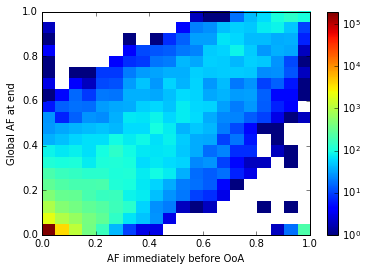

In [14]:
plt.hist2d(traj['af_ANC'],traj['GAF'], bins=np.linspace(0,1,21), norm=mpl.colors.LogNorm())
plt.colorbar()

ax = plt.gca()

ax.set_xlabel('AF immediately before OoA')
ax.set_ylabel('Global AF at end')

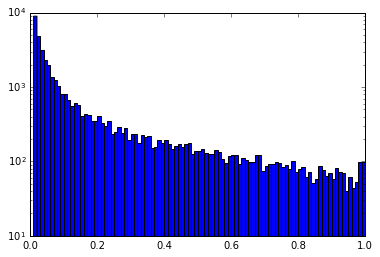

In [15]:
plt.hist(traj['af_ANC'], bins=np.linspace(0.01,1,100), log=True);

In [16]:
anc = traj[traj['af_ANC']>0]

In [17]:
anc.shape

(79450, 9)

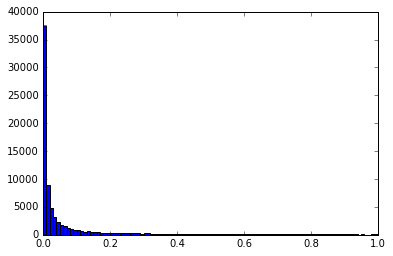

In [18]:
plt.hist(anc['af_ANC'], bins=np.linspace(0,1,101),);

In [19]:
def get_start_end_pop_counts(df, start_lte, end_gt):
    tmp = df.copy()
    tmp = tmp[tmp['af_ANC']<=start_lte]
    tmp['in_AFR'] = tmp.apply(lambda x:True if x['af_AFR']>end_gt else False, axis=1)
    tmp['in_EUR'] = tmp.apply(lambda x:True if x['af_EUR']>end_gt else False, axis=1)
    tmp['in_EAS'] = tmp.apply(lambda x:True if x['af_EAS']>end_gt else False, axis=1)
    
    return tmp.pivot_table(values='af_ANC', index=['in_AFR','in_EUR','in_EAS'], aggfunc=np.count_nonzero, margins=True)

In [20]:
res = get_start_end_pop_counts(anc, 0.01, 0.05)

In [21]:
tmp = anc.copy()

In [22]:
tmp.shape

(79450, 9)

In [23]:
x = tmp[(tmp['af_ANC']<=0.1)]

In [24]:
end_gt = 0.001
y = x[x['GAF']>0.05]
y['in_AFR'] = y.apply(lambda x:True if x['af_AFR']>end_gt else False, axis=1)
y['in_EUR'] = y.apply(lambda x:True if x['af_EUR']>end_gt else False, axis=1)
y['in_EAS'] = y.apply(lambda x:True if x['af_EAS']>end_gt else False, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [25]:
y.shape

(5398, 12)

In [26]:
y.pivot_table(values='af_ANC', index=['in_AFR','in_EUR','in_EAS'], aggfunc=np.count_nonzero, margins=True)

in_AFR  in_EUR  in_EAS
False   False   True        21.0
        True    False       13.0
                True       344.0
True    False   False      349.0
                True       226.0
        True    False      550.0
                True      3895.0
All                       5398.0
Name: af_ANC, dtype: float64

for start_af in [0.001, 0.01, 0.1]:
    for end_af in [0.05]:
        print start_af,end_af
        res = get_start_end_pop_counts(anc, start_af, end_af)
        print res
        print

In [27]:
anc['in_AFR'] = anc.apply(lambda x:True if x['af_AFR']>0.05 else False, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
anc['in_EUR'] = anc.apply(lambda x:True if x['af_EUR']>0.05 else False, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
anc['in_EAS'] = anc.apply(lambda x:True if x['af_EAS']>0.05 else False, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
anc

,af_ANC,af_OOA,af_AFR,af_EUR,af_EAS,GAF,anc_cap,ooa_cap,global_cap,in_AFR,in_EUR,in_EAS
4,0.053,0.000,0.002,0.000,0.000,0.000667,True,False,False,False,False,False
8,0.003,0.000,0.000,0.000,0.000,0.000000,False,False,False,False,False,False
10,0.127,0.159,0.359,0.317,0.104,0.260000,True,True,True,True,True,True
21,0.002,0.000,0.000,0.000,0.000,0.000000,False,False,False,False,False,False
22,0.013,0.000,0.000,0.000,0.000,0.000000,False,False,False,False,False,False
26,0.451,0.559,0.604,0.637,0.533,0.591333,True,True,True,True,True,True
28,0.029,0.000,0.000,0.000,0.000,0.000000,False,False,False,False,False,False
29,0.021,0.000,0.000,0.000,0.000,0.000000,False,False,False,False,False,False
43,0.001,0.000,0.000,0.000,0.000,0.000000,False,False,False,False,False,False
44,0.001,0.000,0.000,0.000,0.000,0.000000,False,False,False,False,False,False


In [31]:
anc.pivot_table(values='af_ANC', index=['in_AFR','in_EUR','in_EAS'], aggfunc=np.count_nonzero, margins=True)

in_AFR  in_EUR  in_EAS
False   False   False     53650.0
                True        664.0
        True    False       941.0
                True       1552.0
True    False   False      7641.0
                True       1085.0
        True    False      1851.0
                True      12066.0
All                       79450.0
Name: af_ANC, dtype: float64

In [32]:
rare = anc[anc['af_ANC']<=0.01]

In [33]:
rare.shape

(38795, 12)

In [34]:
rare.pivot_table(values='af_ANC', index=['in_AFR','in_EUR','in_EAS'], aggfunc=np.count_nonzero, margins=True)

in_AFR  in_EUR  in_EAS
False   False   False     37217.0
                True         98.0
        True    False       227.0
                True        299.0
True    False   False       758.0
                True         23.0
        True    False        34.0
                True        139.0
All                       38795.0
Name: af_ANC, dtype: float64

In [35]:
139/38795

0.003582935945353783

In [36]:
18724/500000

0.037448

In [40]:
rare[rare['GAF']>0.05].shape

(700, 12)

In [41]:
700/38795

0.01804356231473128

In [42]:
rareCaps = rare[rare['GAF']>0.05]

In [44]:
rareCaps.pivot_table(values='af_ANC', index=['in_AFR','in_EUR','in_EAS'], aggfunc=np.count_nonzero, margins=True)

in_AFR  in_EUR  in_EAS
False   False   True       61.0
        True    False      98.0
                True      290.0
True    False   False      60.0
                True       22.0
        True    False      30.0
                True      139.0
All                       700.0
Name: af_ANC, dtype: float64